In [287]:
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek

%matplotlib inline

# Data Cleaning

In [288]:
all_complaints = pd.read_csv('data/DOB_Complaints_Received.csv')
print(list(all_complaints))
print(len(all_complaints))

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Complaint Number', 'Status', 'Date Entered', 'House Number', 'ZIP Code', 'House Street', 'BIN', 'Community Board', 'Special District', 'Complaint Category', 'Unit', 'Disposition Date', 'Disposition Code', 'Inspection Date', 'DOBRunDate']
2299448


### Handle types

In [289]:
all_complaints['Complaint Category'] = all_complaints['Complaint Category'].astype(str)

### Filter down to just Elevators

Number of total complaints: 2299448



Text(0.5, 0, 'Complaint Category')

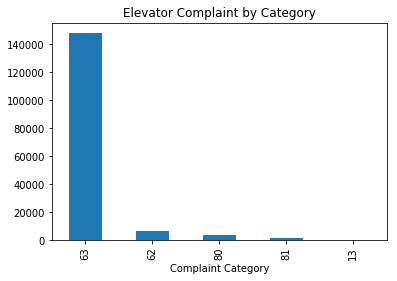

In [17]:
complaint_categories = ['13', '62', '63', '80', '81']


elevator_complaints = all_complaints[all_complaints['Complaint Category'].isin(complaint_categories)]

print("Number of total complaints: {}\n".format(len(all_complaints)))


elevator_complaints['Complaint Category'].value_counts().plot(kind='bar', title='Elevator Complaint by Category').set_xlabel('Complaint Category')

### Filter down to Code 63
Will perform analysis on complaint category 63 (Elevator-Danger Condition/Shaft Open/Unguarded) B because it is the vast majority of elevator complaints and simplifies the problem

In [21]:
complaint_categories = ['63']
elevator_complaints = all_complaints[all_complaints['Complaint Category'].isin(complaint_categories)]
print(elevator_complaints['Complaint Category'].value_counts())

63    148168
Name: Complaint Category, dtype: int64


### Inspections over time

Lengths after cleaning malformed dates: 148164


/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


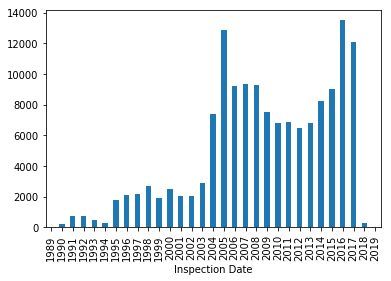

In [22]:
elevator_complaints['Inspection Date'] = pd.to_datetime(elevator_complaints['Inspection Date'],  errors='coerce')
elevator_complaints = elevator_complaints.dropna(subset=['Inspection Date'])
print("Lengths after cleaning malformed dates: {}".format(len(elevator_complaints)))

elevator_complaints.groupby(elevator_complaints['Inspection Date'].dt.year).count()['BIN'].plot(kind='bar')

# CHECK IF THERE ARE ELEVATOR COMPLAINTS IN THE 311 DATASET

### Remove duplicate complaints
TODO: or could this be a feature? Do multiple complaints from a building incrase the likely hood of it being a violation?

In [23]:
print("number of boiler complaints BEFORE dropping duplicates: {}".format(len(elevator_complaints)))
elevator_complaints = elevator_complaints.drop_duplicates(subset=['BIN', 'Date Entered'])
print("number of boiler complaints AFTER dropping duplicates: {}".format(len(elevator_complaints)))

number of boiler complaints BEFORE dropping duplicates: 148164
number of boiler complaints AFTER dropping duplicates: 132897


### Filter down to relevant labels

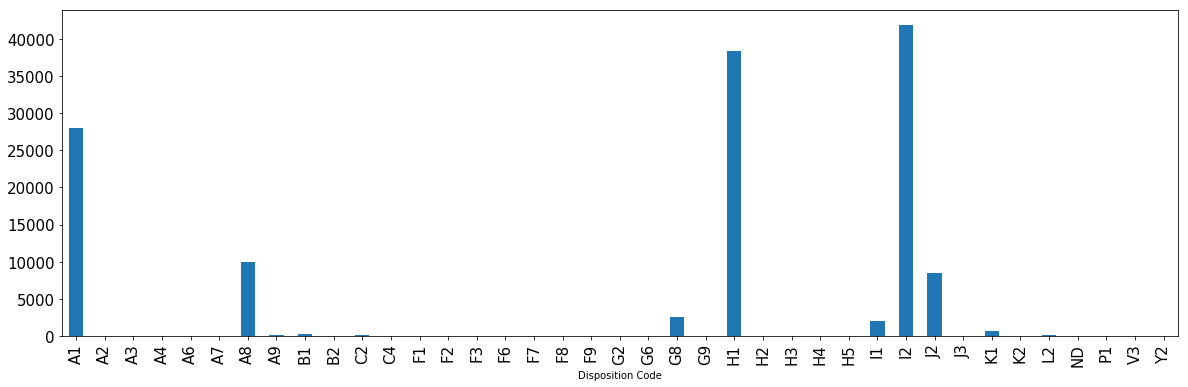

In [24]:
# print(boiler_complaints['Disposition Code'].value_counts())
elevator_complaints.groupby('Disposition Code').count()['BIN'].plot('bar', figsize=(20, 6), fontsize=15)

**Positive**: A8 (ECB Violation Served), A1 (Buildings Violation(s) Served)

**Negative**: I2 (No Violation Warranted for Complaint at Time of Inspection), I1 (Complaint Unsubstantiated Based on Department Records), 

**Note**: H1 (Please See Complaint Number) No documentation as to what this means. J2 (J1?: Follow-Up Inspection to be Scheduled Upon Further Research) No documentation for 'J2' but most likely J1.

In [25]:
positive_labels = ['A1', 'A8']
negative_labels = ['I1', 'I2']
elevator_complaints = elevator_complaints[elevator_complaints['Disposition Code'].isin(positive_labels + negative_labels)]
print("Number of complaints after filter down to relevant dispoisition codes: {}".format(len(elevator_complaints)))

Number of complaints after filter down to relevant dispoisition codes: 81757


# Create Labels

In [26]:
labels = elevator_complaints['Disposition Code'].isin(positive_labels) * 1

In [27]:
print("Percent of labels that are positive (result in violation): {}".format(sum(labels) / len(labels)))

Percent of labels that are positive (result in violation): 0.46388688430348474


# Create Features

In [28]:
elevator_complaints['Violation'] = labels

In [29]:
def violation_ratio_test(column):
    """ Will calculate the ratio of violation to complaints for each category of a given column."""
    return elevator_complaints.groupby(column)['Violation'].sum() / elevator_complaints.groupby(column).count()['Violation']

### Date Features

In [30]:
elevator_complaints['Date Entered'] = pd.to_datetime(elevator_complaints['Date Entered'])
elevator_complaints['Inspection Date'] = pd.to_datetime(elevator_complaints['Inspection Date'])

In [31]:
elevator_complaints['Day'] = elevator_complaints['Date Entered'].apply(lambda date: date.day)

In [32]:
elevator_complaints['Response Time'] = (elevator_complaints['Inspection Date'] - elevator_complaints['Date Entered']).dt.days
print("Length before response time clean: {}".format(len(elevator_complaints)))
elevator_complaints = elevator_complaints[elevator_complaints['Response Time'] >= 0]
print("Length after response time clean: {}".format(len(elevator_complaints)))

Length before response time clean: 81757
Length after response time clean: 81451


### Number of previous elevator complaints

In [33]:
complaint_counts = elevator_complaints.groupby('BIN').apply(lambda row: row['Date Entered'])

In [35]:
elevator_complaints['Previous Complaints'] = elevator_complaints.apply(get_previous_complaints, axis=1 )

### Number of previous elevator violations

In [37]:
violation_counts = elevator_complaints.groupby('BIN').apply(lambda row: row[row['Violation'] == 1]['Date Entered'])

In [38]:
def get_previous_violations(row):
    try:
        violations = violation_counts[row['BIN']]
        return len(violations[violations < row['Date Entered']])
    except:
        return 0

In [39]:
elevator_complaints['Previous Violations'] = elevator_complaints.apply(lambda row: get_previous_violations(row), axis=1)

### Number of previous boiler violations / complaints ratio

In [40]:
elevator_complaints['Violation Ratio'] = (elevator_complaints['Previous Violations'] / elevator_complaints['Previous Complaints']).fillna(0)
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Day,Response Time,Previous Complaints,Previous Violations,Violation Ratio
5438,1005878,CLOSED,1990-03-19,478,10025,CENTRAL PARK WEST,1055724,107,,63,...,08/14/1991,A1,1991-08-05,11/07/2018 12:00:00 AM,1,19,504,0,0,0.0
5460,1005901,CLOSED,1990-03-20,540,10031,WEST 144 STREET,1061892,109,,63,...,10/19/1995,I2,1995-08-21,11/07/2018 12:00:00 AM,0,20,1980,0,0,0.0
5473,1005914,CLOSED,1990-03-21,452,10031,WEST 149 STREET,1061526,109,,63,...,03/05/1992,A1,1992-03-05,11/07/2018 12:00:00 AM,1,21,715,0,0,0.0
5491,1005933,CLOSED,1990-03-21,11,10027,WEST 123 STREET,1053424,110,,63,...,08/11/1992,I2,1992-08-05,11/07/2018 12:00:00 AM,0,21,868,0,0,0.0
5498,1005940,CLOSED,1990-03-22,888,10019,8 AVENUE,1024825,105,,63,...,06/15/1990,A1,1990-06-12,11/07/2018 12:00:00 AM,1,22,82,0,0,0.0


### Number of other complaints

In [42]:
all_complaints['BIN'] = all_complaints['BIN'].astype(str)
elevator_complaints['BIN'] = elevator_complaints['BIN'].astype(str)

bin_to_complaint_counts = all_complaints['BIN'].value_counts()

def get_all_previous_complaints(row): 
    return (bin_to_complaint_counts[row['BIN']])

elevator_complaints['All Complaints'] = elevator_complaints.apply(lambda row: get_all_previous_complaints(row), axis=1)
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,Disposition Code,Inspection Date,DOBRunDate,Violation,Day,Response Time,Previous Complaints,Previous Violations,Violation Ratio,All Complaints
5438,1005878,CLOSED,1990-03-19,478,10025,CENTRAL PARK WEST,1055724,107,,63,...,A1,1991-08-05,11/07/2018 12:00:00 AM,1,19,504,0,0,0.0,22
5460,1005901,CLOSED,1990-03-20,540,10031,WEST 144 STREET,1061892,109,,63,...,I2,1995-08-21,11/07/2018 12:00:00 AM,0,20,1980,0,0,0.0,47
5473,1005914,CLOSED,1990-03-21,452,10031,WEST 149 STREET,1061526,109,,63,...,A1,1992-03-05,11/07/2018 12:00:00 AM,1,21,715,0,0,0.0,56
5491,1005933,CLOSED,1990-03-21,11,10027,WEST 123 STREET,1053424,110,,63,...,I2,1992-08-05,11/07/2018 12:00:00 AM,0,21,868,0,0,0.0,45
5498,1005940,CLOSED,1990-03-22,888,10019,8 AVENUE,1024825,105,,63,...,A1,1990-06-12,11/07/2018 12:00:00 AM,1,22,82,0,0,0.0,49


# Question: How effective is the DOB at prioritizing complaints that result in violations?

### Violations and Complaint response time

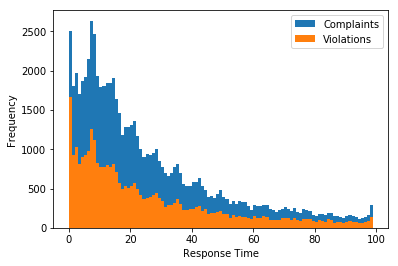

In [69]:
response_time_violation = elevator_complaints[elevator_complaints['Violation'] == 1]['Response Time']

plt.hist([elevator_complaints['Response Time']], bins=range(100), label='Complaints')
plt.hist([response_time_violation], bins=range(100), label='Violations')
plt.xlabel('Response Time')
plt.ylabel('Frequency')
plt.legend()

### How quickly are violations responded to?

In [89]:
day_interval = 7
response_time_percent = len(response_time_violation[response_time_violation < day_interval]) / len(response_time_violation) * 100
print("{}% of complaints that result in violations are inspected within {} days".format(response_time_percent, day_interval))

19.219044084510774% of complaints that result in violations are inspected within 7 days


### How effective is the DOB priority?

#### Create a Priority Score

In [90]:
from statistics import mean

def accuracy_priority_score(scores_by_day):
    
    priorities = pd.DataFrame(list(scores_by_day.values))
    print("Average True positive Accuracy: {}".format(priorities[0].dropna().mean()))
    print("Average True Negative Accuracy: {}".format(priorities[1].dropna().mean()))

def day_priority_score(violations):
#     print(violations)
    number_of_violations = violations.sum()

    true_positive_accuracy = violations[:number_of_violations].sum() / number_of_violations
    true_negative_accuracy = (~violations[number_of_violations:].astype(bool)).sum() / (len(violations) - number_of_violations) 
    
    return [true_positive_accuracy, true_negative_accuracy]   

In [113]:
#### Random Score
random_by_day = elevator_complaints.groupby('Date Entered').apply(lambda row: day_priority_score(row.sample(frac=1)['Violation']))

print("\nRandom \n -------------------------")
accuracy_priority_score(random_by_day)
####

#### Baseline Score
baseline_by_day = elevator_complaints.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Response Time')['Violation']))

print("\nBaseline \n -------------------------")
accuracy_priority_score(baseline_by_day)
####

#### Perfect Model
perfect_by_day = elevator_complaints.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Violation', ascending=False)['Violation']))

print("\nSanity Check: Perfect Accuracy (Rank by the label) \n -------------------------")
accuracy_priority_score(perfect_by_day)
####

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  



Random 
 -------------------------
Average True positive Accuracy: 0.5173391386953707
Average True Negative Accuracy: 0.5594805041313732

Baseline 
 -------------------------
Average True positive Accuracy: 0.5224509414238011
Average True Negative Accuracy: 0.56963236865098

Sanity Check: Perfect Accuracy (Rank by the label) 
 -------------------------
Average True positive Accuracy: 1.0
Average True Negative Accuracy: 1.0


The DOB prioritization method is preforming slightly better than randomly inspecting complaints for a given day. 

#### Violation and Complaint Breakdown by day

In [101]:
# response_time_range = 20
# response_time_bar = []

# for i in range(response_time_range):
#     positive_complaints = elevator_complaints[elevator_complaints['Violation'] == 1]
#     negative_complaints = elevator_complaints[elevator_complaints['Violation'] == 0]
    
#     positive_response_time = positive_complaints[positive_complaints['Response Time'] == i]
#     negative_response_time = negative_complaints[negative_complaints['Response Time'] == i]
    
#     response_time_bar.append([len(negative_response_time), len(positive_response_time)])
    
# pd.DataFrame(response_time_bar).plot(kind='bar')

### What happens if we prioritize complaints for a given day by (violation / complaint) ratio?

In [114]:
ratio_by_day = elevator_complaints.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Violation Ratio', ascending=False)['Violation']))

print("Prioritize based on violation ratio history \n -------------------------")
accuracy_priority_score(ratio_by_day)
####

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


Prioritize based on violation ratio history 
 -------------------------
Average True positive Accuracy: 0.584791536405736
Average True Negative Accuracy: 0.6247653836591202


## Question: Can we improve prioritization using classifier with more features?

# Building Features

### Bin to BBL

In [115]:
bin_to_bbl = pd.read_csv('data/pad19a/bobaadr.txt')

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
bin_to_bbl.head()

,boro,block,lot,bin,lhnd,lhns,lcontpar,lsos,hhnd,hhns,...,addrtype,realb7sc,validlgcs,dapsflag,naubflag,parity,b10sc,segid,zipcode,physical_id
0,1,1,10,1089249,,,,L,,,...,N,,01,,,0,10007401010,0132761,10004,
1,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077201010,0117705,10004,0138883
2,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077301010,0115073,10004,0175748
3,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077401010,0018085,10004,0097424
4,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077501010,0299272,10004,0174909


In [117]:
def format_bbl(row):
    boro = str(row['boro'])
    block = str(row['block'])
    lot = str(row['lot'])
    
    return boro + block.zfill(5) + lot.zfill(4)

In [118]:
bin_to_bbl['bbl'] = bin_to_bbl.apply(format_bbl, axis=1)

In [119]:
bin_to_bbl['bin'] = bin_to_bbl['bin'].astype(str)

elevator_complaints = pd.merge(elevator_complaints, bin_to_bbl[['bin', 'bbl']], left_on='BIN', right_on='bin', how='left').drop_duplicates(subset=['Complaint Number'])
print(elevator_complaints['bbl'].isna().value_counts())
elevator_complaints = elevator_complaints.dropna(subset=['bbl'])
print(elevator_complaints['bbl'].isna().value_counts())

False    80833
True       618
Name: bbl, dtype: int64
False    80833
Name: bbl, dtype: int64


In [120]:
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,DOBRunDate,Violation,Day,Response Time,Previous Complaints,Previous Violations,Violation Ratio,All Complaints,bin,bbl
0,1005878,CLOSED,1990-03-19,478,10025,CENTRAL PARK WEST,1055724,107,,63,...,11/07/2018 12:00:00 AM,1,19,504,0,0,0.0,22,1055724,1018441001
2,1005901,CLOSED,1990-03-20,540,10031,WEST 144 STREET,1061892,109,,63,...,11/07/2018 12:00:00 AM,0,20,1980,0,0,0.0,47,1061892,1020750049
3,1005914,CLOSED,1990-03-21,452,10031,WEST 149 STREET,1061526,109,,63,...,11/07/2018 12:00:00 AM,1,21,715,0,0,0.0,56,1061526,1020630054
4,1005933,CLOSED,1990-03-21,11,10027,WEST 123 STREET,1053424,110,,63,...,11/07/2018 12:00:00 AM,0,21,868,0,0,0.0,45,1053424,1017210045
5,1005940,CLOSED,1990-03-22,888,10019,8 AVENUE,1024825,105,,63,...,11/07/2018 12:00:00 AM,1,22,82,0,0,0.0,49,1024825,1010240001


### Merge With Pluto

In [121]:
pluto = pd.read_csv('data/pluto_more_features.csv')
list(pluto)

['exempttot',
 'address',
 'bbl',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'ownertype',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

In [122]:
# for col in list(pluto):
#     print(col)
#     print(pluto[col].isna().value_counts())
#     print()

In [123]:
pluto = pluto.drop(['ownertype'], axis=1)

In [124]:
pluto['bbl'] = pluto['bbl'].astype(str)
elevator_complaints = pd.merge(elevator_complaints, pluto, on='bbl', how='left')

In [125]:
print(elevator_complaints['yearbuilt'].isna().value_counts())
elevator_complaints = elevator_complaints.dropna()
print(elevator_complaints['yearbuilt'].isna().value_counts())

False    76394
True      4439
Name: yearbuilt, dtype: int64
False    76380
Name: yearbuilt, dtype: int64


# Model

In [200]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [201]:
list(elevator_complaints)

['Complaint Number',
 'Status',
 'Date Entered',
 'House Number',
 'ZIP Code',
 'House Street',
 'BIN',
 'Community Board',
 'Special District',
 'Complaint Category',
 'Unit',
 'Disposition Date',
 'Disposition Code',
 'Inspection Date',
 'DOBRunDate',
 'Violation',
 'Day',
 'Response Time',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'All Complaints',
 'bin',
 'bbl',
 'exempttot',
 'address',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

### Select and Encode Features

In [263]:
categorical = ['ZIP Code', 'landuse', 'cb2010', 'bldgclass']

elevator_complaints[categorical] = elevator_complaints[categorical].apply(lambda col: col.astype('category').cat.codes)
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,bbl,exempttot,address,bldgclass,cb2010,assesstot,landuse,yearalter1,yearalter2,yearbuilt
1,1005901,CLOSED,1990-03-20,540,29,WEST 144 STREET,1061892,109,,63,...,1020750049,921600.0,540 WEST 144 STREET,23,106,921600.0,2,1989.0,0.0,1910.0
2,1005914,CLOSED,1990-03-21,452,29,WEST 149 STREET,1061526,109,,63,...,1020630054,771312.0,452 WEST 149 STREET,23,53,1242000.0,2,1987.0,0.0,1902.0
3,1005933,CLOSED,1990-03-21,11,25,WEST 123 STREET,1053424,110,,63,...,1017210045,0.0,15 WEST 123 STREET,23,54,646200.0,2,1988.0,0.0,1935.0
4,1005940,CLOSED,1990-03-22,888,17,8 AVENUE,1024825,105,,63,...,1010240001,0.0,870 8 AVENUE,28,54,34980750.0,3,0.0,0.0,1965.0
5,1005949,CLOSED,1990-03-22,60,3,EAST 11 STREET,1009105,102,,63,...,1005620014,0.0,60 EAST 11 STREET,90,53,3443400.0,5,0.0,0.0,1930.0


In [264]:
print(len(elevator_complaints))
elevator_complaints = elevator_complaints.dropna()
print(len(elevator_complaints))

76380
76380


In [265]:
# X = elevator_complaints[included_features]
X = elevator_complaints
y = elevator_complaints['Violation']

In [266]:
def group_train_test_splits(X, y, groups, test_size=0.15):
    gs = GroupShuffleSplit(n_splits=1, test_size=test_size).split(X, y, groups=groups)
    
    for ii, (train, test) in enumerate(gs):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
    return X_train, X_test, y_train, y_test

In [267]:
groups = elevator_complaints['BIN'].astype('category').cat.codes
X_train, X_test, y_train, y_test = group_train_test_splits(X, y, groups)

print("Training Data size: {}".format(len(X_train)))
print("Testing Data size: {}".format(len(X_test)))
print("Testing Data %: {}".format(len(X_test) / len(X_train)))
print(set(X_train['BIN']) & set(X_test['BIN']))
print()

Training Data size: 64566
Testing Data size: 11814
Testing Data %: 0.18297555989220332
set()



In [268]:
groups = X_train['BIN'].astype('category').cat.codes

X_train, X_val, y_train, y_val = group_train_test_splits(X_train, y_train, groups)

print("Training Data size: {}".format(len(X_train)))
print("Validation Data size: {}".format(len(X_val)))
print("Testing Data size: {}".format(len(X_test)))
print("Validation Data %: {}".format(len(X_val) / len(X_train)))
print(set(X_train['BIN']) & set(X_val['BIN']) & set(X_test['BIN']))
print()
### BALANCE
print("training Data Balance: {}".format(y_train.sum() / len(y_train)))
print("val Data Balance: {}".format(y_val.sum() / len(y_val)))
print("test Data Balance: {}".format(y_test.sum() / len(y_test)))
# X_train = X_train.drop(["BIN"], axis=1)
# X_val = X_val.drop(["BIN"], axis=1)
# X_test = X_test.drop(["BIN"], axis=1)

Training Data size: 54984
Validation Data size: 9582
Testing Data size: 11814
Validation Data %: 0.1742688782191183
set()

training Data Balance: 0.46806343663611233
val Data Balance: 0.4685869338342726
test Data Balance: 0.45996275605214154


### Plot train and test feature distributions

In [269]:
# for feature in list(X_train):
#     print(feature)
#     print("Training")
#     plt.hist(X_train[feature])
#     plt.show()
#     print("Val")
#     plt.hist(X_val[feature])
#     plt.show()    
#     print("Test")
#     plt.hist(X_test[feature])
#     plt.show()    

### Select Features

In [270]:
included_features = [
 'ZIP Code',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'All Complaints',
 'Day',
 'assesstot',
 'landuse',
 'yearalter1',
 'yearalter2',
 'yearbuilt',
 'exempttot',
 'bldgclass',
 'cb2010']

In [271]:
# X = elevator_complaints[included_features]
# # X = elevator_complaints
# y = elevator_complaints['Violation']
eval_cols = ['BIN', 'Response Time', 'Violation', 'Date Entered']

train_eval_cols = X_train[eval_cols]
val_eval_cols = X_val[eval_cols]
test_eval_cols = X_test[eval_cols]

X_train = X_train[included_features]
X_val = X_val[included_features]
X_test = X_test[included_features]

# Train Model

### Try Different params

In [286]:
max_depth_range = 30
best_model = None
best_val = 0

for max_depth in range(1, max_depth_range):
    print("Training Forest with max depth = {}".format(max_depth))
    clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=None)
    clf.fit(X_train, y_train)

    # print("Testing Data Balance: {}".format(y_train.sum() / len(y_train)))
    print("Training accuracy: {}".format(clf.score(X_train, y_train)))
    # print("Val Data Balance: {}".format(y_test.sum() / len(y_test)))
    val_accuracy = clf.score(X_val, y_val)
    print("Val accuracy: {}".format(val_accuracy))
    feature_importances = pd.DataFrame(clf.feature_importances_, list(X_train))

    if val_accuracy > best_val:
        best_model = clf
        best_val = val_accuracy

Training Forest with max depth = 1
Training accuracy: 0.5642004946893642


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [275]:
clf = best_model
print("Training accuracy: {}".format(clf.score(X_train, y_train)))
# print("Val Data Balance: {}".format(y_test.sum() / len(y_test)))
val_accuracy = clf.score(X_val, y_val)
print("Val accuracy: {}".format(val_accuracy))
feature_importances = pd.DataFrame(clf.feature_importances_, list(X_train))


Training accuracy: 0.7102975411028662
Val accuracy: 0.5921519515758714


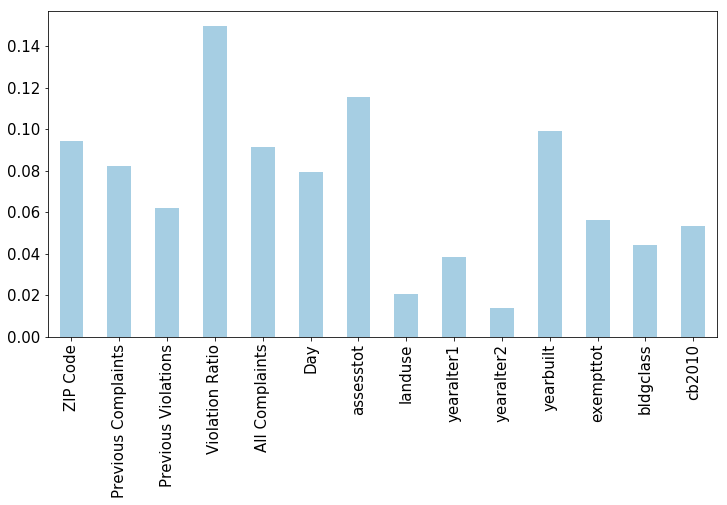

In [276]:
feature_importances.plot(kind='bar', legend=False, colormap='Paired', stacked=True, figsize=(12,6), fontsize=15)

# Metrics

In [277]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels

### ROC Curve

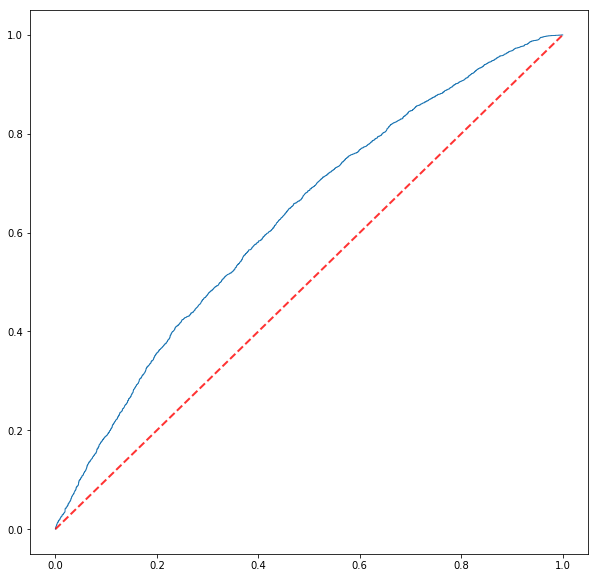

In [278]:
y_predict_probs = clf.predict_proba(X_val)
y_preds = clf.predict(X_val)
# print(clf.classes_)
# print(y_predict_probs)

fpr, tpr, thresholds = roc_curve(y_val, y_predict_probs[:,1])

roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))

plt.plot(fpr, tpr, lw=1, alpha=1,
         label='ROC')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

In [279]:
### Confusion Matrix

In [280]:
# Code frome: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    plt.figure(figsize=(15,15))
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
    thresh = 0.5
    print(thresh)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[0 1]
Confusion matrix, without normalization
[[3461 1631]
 [2277 2213]]
0.5
[0 1]
Normalized confusion matrix
[[0.68 0.32]
 [0.51 0.49]]
0.5


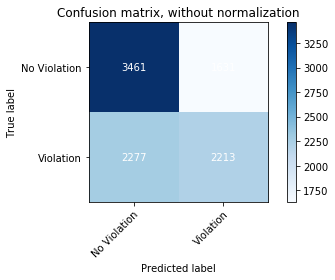

<Figure size 1080x1080 with 0 Axes>

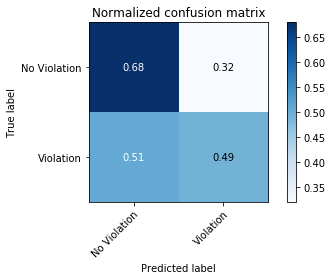

<Figure size 1080x1080 with 0 Axes>

In [281]:
np.set_printoptions(precision=2)

class_names = ['No Violation', 'Violation']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Order Score for Val

In [282]:
X_val = pd.concat([X_val, val_eval_cols], axis=1)

In [283]:
X_val['Priority'] = y_predict_probs[:,1]

In [284]:
#### Random Score
random_by_day = X_val.groupby('Date Entered').apply(lambda row: day_priority_score(row.sample(frac=1)['Violation']))

print("\nRandom \n -------------------------")
accuracy_priority_score(random_by_day)
####

#### Perfect Model
perfect_by_day = X_val.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Violation', ascending=False)['Violation']))

print("\nSanity Check: Perfect Accuracy (Rank by the label) \n -------------------------")
accuracy_priority_score(perfect_by_day)
####

#### Baseline Score
baseline_by_day = X_val.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Response Time')['Violation']))

print("\nBaseline (DOB Ordering) \n -------------------------")
accuracy_priority_score(baseline_by_day)
####

#### Model Score
model_by_day = X_val.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Priority', ascending=False)['Violation']))

print("\nModel \n -------------------------")
accuracy_priority_score(model_by_day)
####

#### Rank by Violation Ratio Score
violation_ratio_by_day = X_val.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Violation Ratio', ascending=False)['Violation']))

print("\n Violation Ratio Score \n -------------------------")
accuracy_priority_score(violation_ratio_by_day)
####

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  



Random 
 -------------------------
Average True positive Accuracy: 0.7454243982412996
Average True Negative Accuracy: 0.7685832337714057

Sanity Check: Perfect Accuracy (Rank by the label) 
 -------------------------
Average True positive Accuracy: 1.0
Average True Negative Accuracy: 1.0

Baseline (DOB Ordering) 
 -------------------------
Average True positive Accuracy: 0.7533638870258589
Average True Negative Accuracy: 0.7802689594356261

Model 
 -------------------------
Average True positive Accuracy: 0.798557269543185
Average True Negative Accuracy: 0.8170499800876145

 Violation Ratio Score 
 -------------------------
Average True positive Accuracy: 0.778397794172442
Average True Negative Accuracy: 0.7992155942424759
